# Deep Learning in Computer vision

# tasks
1. LeNet
2. Validation
3. Validation loss
4. Epoch acc.
5. Loss curve
6. Normalization
7. Errors (why?)

# convolution and correlation

In [1]:
import cv2
from scipy.signal import correlate2d, convolve2d

import numpy as np

from IPython.display import clear_output

import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from IPython.display import clear_output

from collections import defaultdict

import seaborn as sn
import pandas as pd

In [2]:
arr = [1,4, 3,4 ,5 ,6]
a = np.median(arr)

In [3]:
a.dtype

dtype('float64')

In [4]:
def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('class probability')
    ax2.set_xlabel('probability')
    ax2.set_ylabel('class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [5]:
def show_features(features):
    if len(features.shape) < 4:
        batch, num_feature = features.shape[:2]
        for i, feature in enumerate(features):
            plt.subplot(1, num_feature, i+1)
            plt.imshow(feature.numpy().transpose(1,2,0))
    else:
        batch, num_feature = features.shape[:2]
        for i, element in enumerate(features):
            for j, feature in enumerate(element):
                plt.subplot(batch, num_feature, i * num_feature + j + 1)
                plt.imshow(feature.numpy())

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
T = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

In [8]:
num, height, width = np.array(train_data.data).shape
img_min = np.array(train_data.data).min()
img_max = np.array(train_data.data).max()
img_norm_mean = np.array(train_data.data, dtype=float).mean() / img_max
img_std = np.sqrt(np.sum((np.array(train_data.data) / img_max  - img_norm_mean) ** 2) / (num * height * width))
print(img_min, img_max, img_norm_mean, img_std)

0 255 0.1306604762738429 0.3081078038564622


In [9]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((img_norm_mean,), (img_std,)) # normalize inputs
])

train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

In [10]:
print('train set shape: ', train_data.data.shape)
print('train labels shape: ', train_data.targets.shape)

train set shape:  torch.Size([60000, 28, 28])
train labels shape:  torch.Size([60000])


In [11]:
print('test set shape: ', test_data.data.shape)
print('test labels shape: ', test_data.targets.shape)

test set shape:  torch.Size([10000, 28, 28])
test labels shape:  torch.Size([10000])


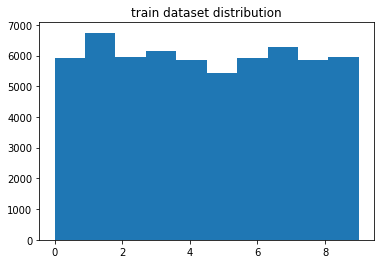

In [12]:
plt.title('train dataset distribution')
plt.hist(train_data.targets);

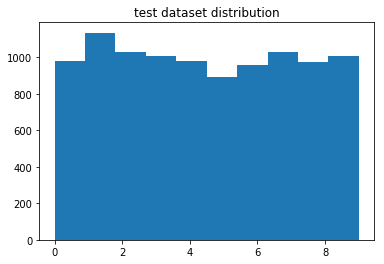

In [13]:
plt.title('test dataset distribution')
plt.hist(test_data.targets);

In [22]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [24]:
train_data.targets.shape

torch.Size([60000])

In [14]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=8, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=8, 
                                          shuffle=False)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

tensor([2, 9, 9, 1, 6, 1, 9, 7])


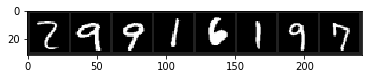

In [15]:
images, labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images)[0,:,:], cmap='gray')
print(labels)

# LeNet - 5

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=10, 
                               kernel_size=5, 
                               padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, 
                               out_channels=20, 
                               kernel_size=3, 
                               padding=0)
        self.fc1 = nn.Linear(20 * 5 * 5, 216)
        self.fc2 = nn.Linear(216, 151)
        self.fc3 = nn.Linear(151, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
#         x = F.max_pool2d(F.relu(self.conv1(x)),2)
#         x = F.max_pool2d(F.relu(self.conv2(x)),2)
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
#         x = F.max_pool2d(F.relu(self.conv1(x)),2)
        return x

In [17]:
net = Net().to(device)
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

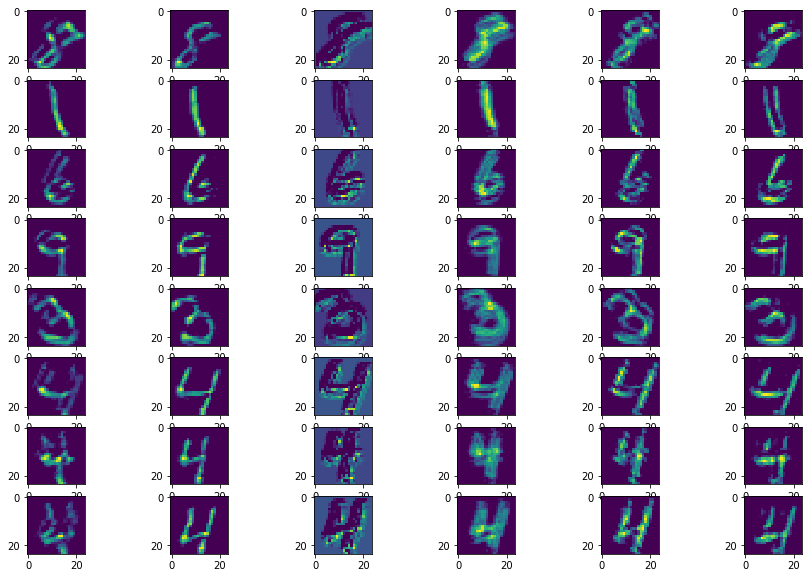

In [18]:
plt.figure(figsize=(15,10))
show_features(net.features_1(images.to(device)).detach().cpu())

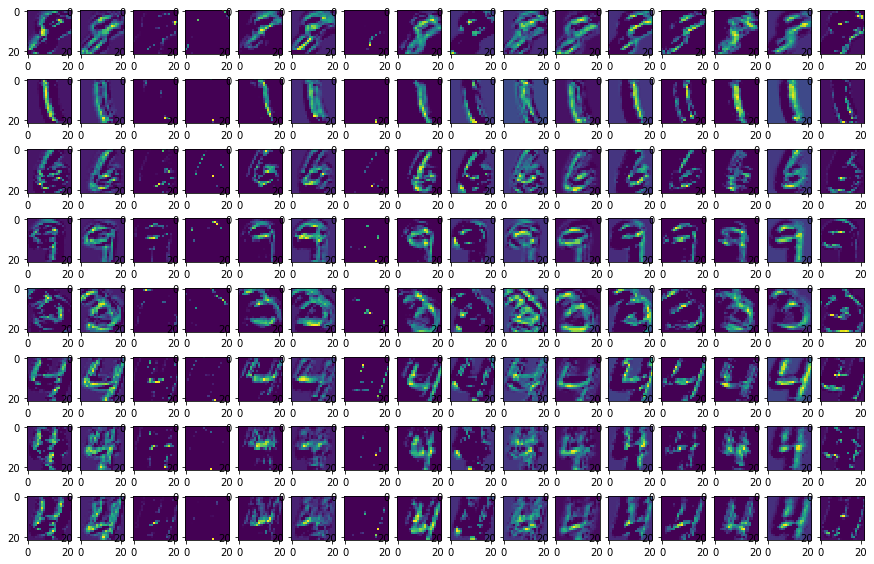

In [19]:
plt.figure(figsize=(15,10))
show_features(net.features_2(images.to(device)).detach().cpu())

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

epoch=0

curve_x=[]
loss_curve_y=[]
v_loss_curve_y=[]
acc_curve_y=[]

In [21]:
num_epochs=100

e=0
while e < num_epochs:
    epoch+=1
    e+=1

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 1000 == 999:    
            validation_loss = 0.
            correct = 0
            total = 0

            with torch.no_grad():
                net.eval()

                for v_data in test_loader:
                    v_inputs, v_labels = v_data[0].to(device), v_data[1].to(device)

                    v_outputs = net(v_inputs)
                    v_loss = criterion(v_outputs, v_labels)

                    validation_loss+=v_loss.item()

                    _, predicted = torch.max(v_outputs.data, 1)
                    total += v_labels.size(0)
                    correct += (predicted == v_labels).sum().item()
            net.train()
        #     clear_output()              
            print('epoch %d, step %5d training loss: %.3f validation loss: %.3f test acc: %.3f' %
              (epoch, i + 1, running_loss / 1000, validation_loss/1000, 100 * correct / total))
            
            curve_x.append(len(curve_x))
            loss_curve_y.append(running_loss/1000)
            v_loss_curve_y.append(validation_loss/1000)
            acc_curve_y.append(100 * correct / total)
            
            running_loss = 0.0

print('finish')

epoch 1, step  1000 training loss: 2.296 validation loss: 2.851 test acc: 12.090
epoch 1, step  2000 training loss: 2.257 validation loss: 2.770 test acc: 51.430
epoch 1, step  3000 training loss: 2.078 validation loss: 2.218 test acc: 63.990
epoch 1, step  4000 training loss: 1.143 validation loss: 0.831 test acc: 81.460
epoch 1, step  5000 training loss: 0.552 validation loss: 0.570 test acc: 86.660
epoch 1, step  6000 training loss: 0.452 validation loss: 0.488 test acc: 88.110
epoch 1, step  7000 training loss: 0.383 validation loss: 0.416 test acc: 90.170
epoch 2, step  1000 training loss: 0.313 validation loss: 0.378 test acc: 91.140
epoch 2, step  2000 training loss: 0.287 validation loss: 0.320 test acc: 92.380
epoch 2, step  3000 training loss: 0.250 validation loss: 0.279 test acc: 93.390
epoch 2, step  4000 training loss: 0.248 validation loss: 0.270 test acc: 93.700
epoch 2, step  5000 training loss: 0.238 validation loss: 0.254 test acc: 94.050
epoch 2, step  6000 training

epoch 29, step  4000 training loss: 0.021 validation loss: 0.045 test acc: 98.710
epoch 29, step  5000 training loss: 0.022 validation loss: 0.045 test acc: 98.960
epoch 29, step  6000 training loss: 0.023 validation loss: 0.046 test acc: 98.710
epoch 29, step  7000 training loss: 0.023 validation loss: 0.047 test acc: 98.840
epoch 30, step  1000 training loss: 0.016 validation loss: 0.042 test acc: 98.840
epoch 30, step  2000 training loss: 0.020 validation loss: 0.045 test acc: 98.820
epoch 30, step  3000 training loss: 0.019 validation loss: 0.044 test acc: 98.860
epoch 30, step  4000 training loss: 0.021 validation loss: 0.041 test acc: 98.830
epoch 30, step  5000 training loss: 0.021 validation loss: 0.041 test acc: 98.910
epoch 30, step  6000 training loss: 0.024 validation loss: 0.039 test acc: 98.940
epoch 30, step  7000 training loss: 0.024 validation loss: 0.043 test acc: 98.830
epoch 31, step  1000 training loss: 0.021 validation loss: 0.049 test acc: 98.720
epoch 31, step  

epoch 57, step  6000 training loss: 0.006 validation loss: 0.043 test acc: 98.990
epoch 57, step  7000 training loss: 0.006 validation loss: 0.048 test acc: 98.990
epoch 58, step  1000 training loss: 0.005 validation loss: 0.044 test acc: 99.100
epoch 58, step  2000 training loss: 0.005 validation loss: 0.048 test acc: 98.980
epoch 58, step  3000 training loss: 0.005 validation loss: 0.044 test acc: 99.010
epoch 58, step  4000 training loss: 0.005 validation loss: 0.045 test acc: 98.930
epoch 58, step  5000 training loss: 0.005 validation loss: 0.044 test acc: 98.950
epoch 58, step  6000 training loss: 0.006 validation loss: 0.042 test acc: 99.010
epoch 58, step  7000 training loss: 0.004 validation loss: 0.045 test acc: 99.040
epoch 59, step  1000 training loss: 0.003 validation loss: 0.045 test acc: 99.030
epoch 59, step  2000 training loss: 0.005 validation loss: 0.045 test acc: 99.110
epoch 59, step  3000 training loss: 0.007 validation loss: 0.046 test acc: 99.000
epoch 59, step  

epoch 86, step  1000 training loss: 0.002 validation loss: 0.050 test acc: 98.990
epoch 86, step  2000 training loss: 0.001 validation loss: 0.051 test acc: 99.090
epoch 86, step  3000 training loss: 0.003 validation loss: 0.053 test acc: 98.970
epoch 86, step  4000 training loss: 0.001 validation loss: 0.052 test acc: 99.050
epoch 86, step  5000 training loss: 0.001 validation loss: 0.051 test acc: 99.070
epoch 86, step  6000 training loss: 0.001 validation loss: 0.053 test acc: 99.030
epoch 86, step  7000 training loss: 0.001 validation loss: 0.052 test acc: 99.070
epoch 87, step  1000 training loss: 0.002 validation loss: 0.052 test acc: 98.980
epoch 87, step  2000 training loss: 0.002 validation loss: 0.051 test acc: 99.050
epoch 87, step  3000 training loss: 0.002 validation loss: 0.052 test acc: 99.060
epoch 87, step  4000 training loss: 0.002 validation loss: 0.052 test acc: 99.110
epoch 87, step  5000 training loss: 0.001 validation loss: 0.052 test acc: 99.060
epoch 87, step  

# training curves

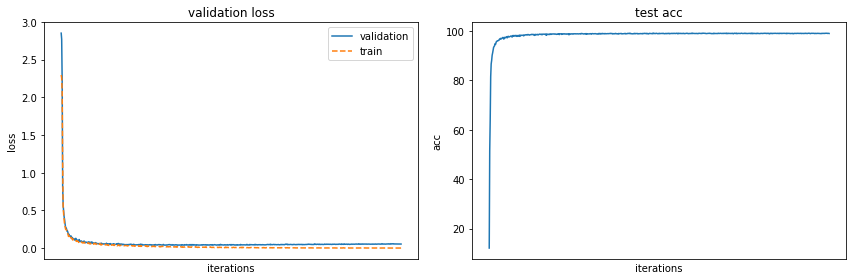

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(curve_x,v_loss_curve_y, label='validation')
axes[0].plot(curve_x,loss_curve_y, '--',label='train')
axes[0].set_title('validation loss')
axes[0].set_xlabel("iterations")
axes[0].set_ylabel("loss")
axes[0].set_xticks([])
axes[0].legend()
axes[1].plot(curve_x,acc_curve_y)
axes[1].set_title('test acc')
axes[1].set_xlabel("iterations")
axes[1].set_ylabel("acc")
axes[1].set_xticks([])
fig.tight_layout()
plt.show()

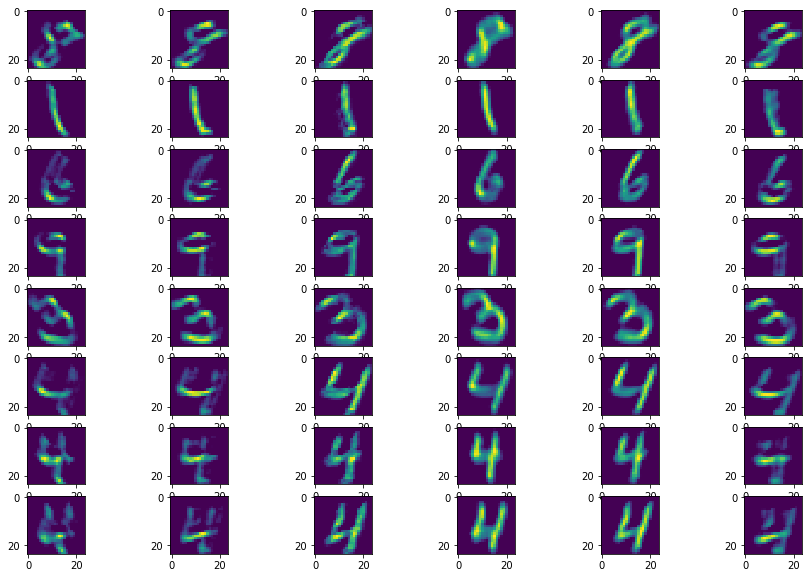

In [23]:
plt.figure(figsize=(15,10))
show_features(net.features_1(images.to(device)).detach().cpu())

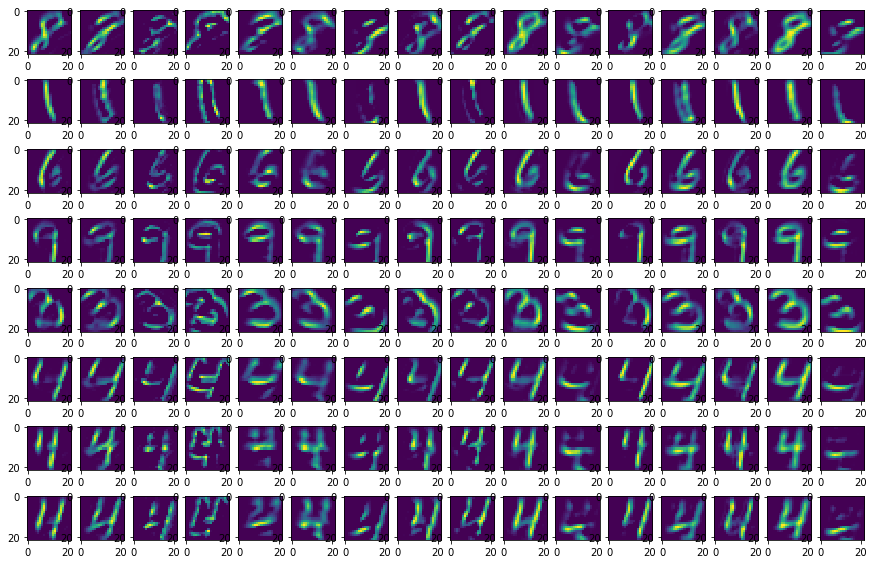

In [24]:
plt.figure(figsize=(15,10))
show_features(net.features_2(images.to(device)).detach().cpu())

gt: tensor([7, 2, 1, 0, 4, 1, 4, 9], device='cuda:0')
predict: tensor([7, 2, 1, 0, 4, 1, 4, 9], device='cuda:0')


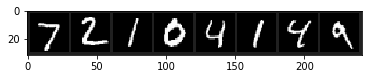

In [25]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

plt.imshow(torchvision.utils.make_grid(images.cpu())[0,:,:], cmap='gray')
print('gt:', labels)
print('predict:', predicted)

In [26]:
correct = 0
total = 0

errors_imgs=[]
errors_labels=[]
confusion_matrix = torch.zeros(10, 10)
err_confusion_matrix = torch.zeros(10, 10)
correct_samples={i:None for i in range(10)}
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        errors_imgs.extend(images[torch.where(predicted != labels)])
        errors_labels.extend(zip(predicted[torch.where(predicted != labels)], labels[torch.where(predicted != labels)]))
        
        for i in [i for i in correct_samples if type(correct_samples[i]) != torch.Tensor]:
            ci = images[torch.where(predicted == labels)][torch.where(i == labels)]
            if ci.shape[0] > 0:
                correct_samples[i] = ci[0]
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            if t.long() != p.long():
                err_confusion_matrix[t.long(), p.long()] += 1
errors_imgs=torch.stack(errors_imgs)
errors_labels=np.array([(p.item(), t.item())for p, t in errors_labels])
print('accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
torch.save(net, 'torch_mnist_model.pt')  

accuracy of the network on the 10000 test images: 99 %


D:\Anaconda\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [27]:
print('errors: ',len(errors_labels))

errors:  99


# heatmap

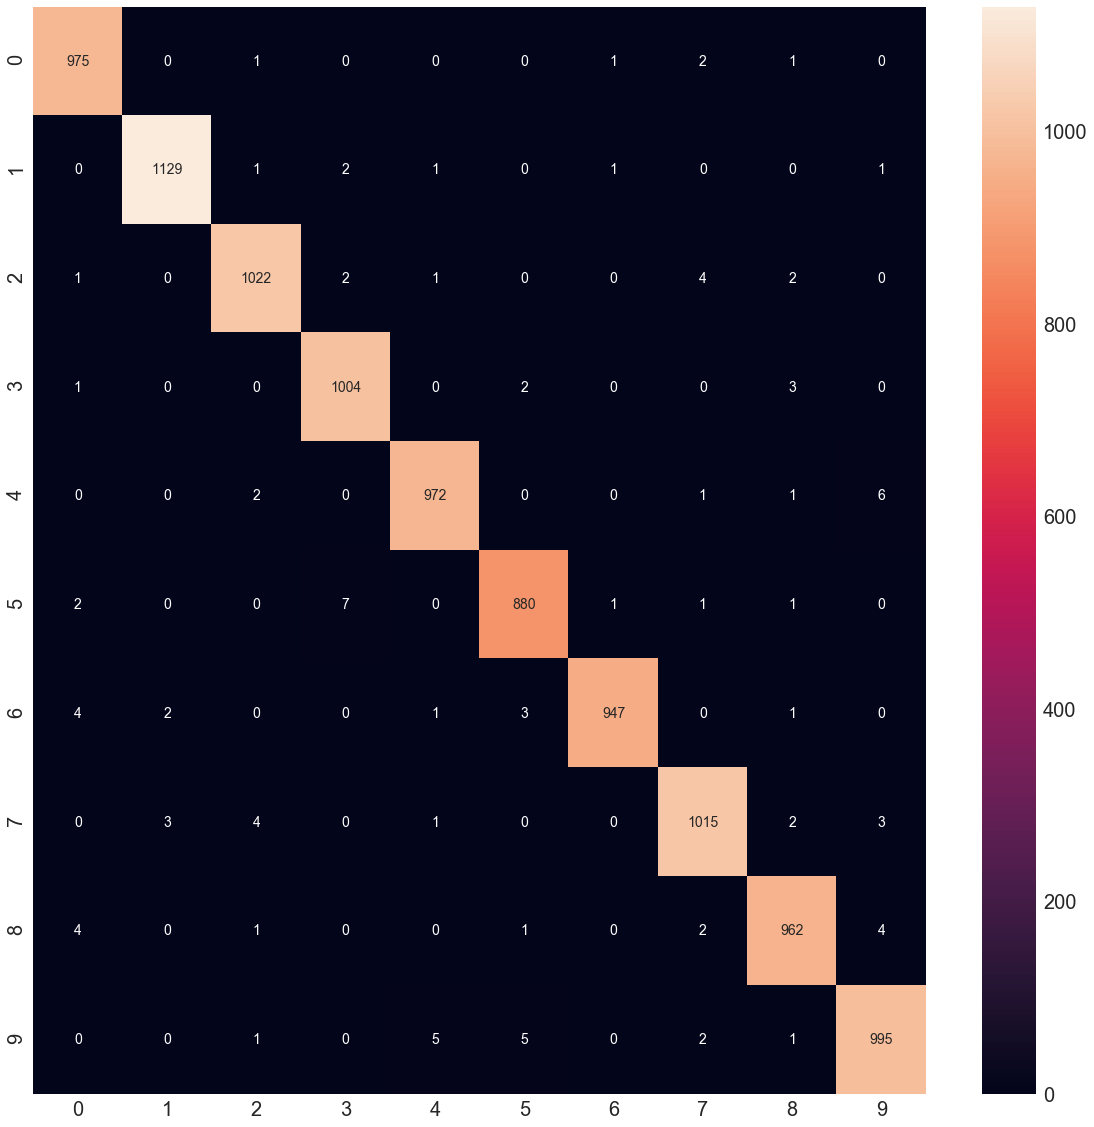

In [28]:
df_cm = pd.DataFrame(confusion_matrix.numpy(), range(10), range(10))

plt.figure(figsize = (20,20))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, fmt='g')

# errors heatmap

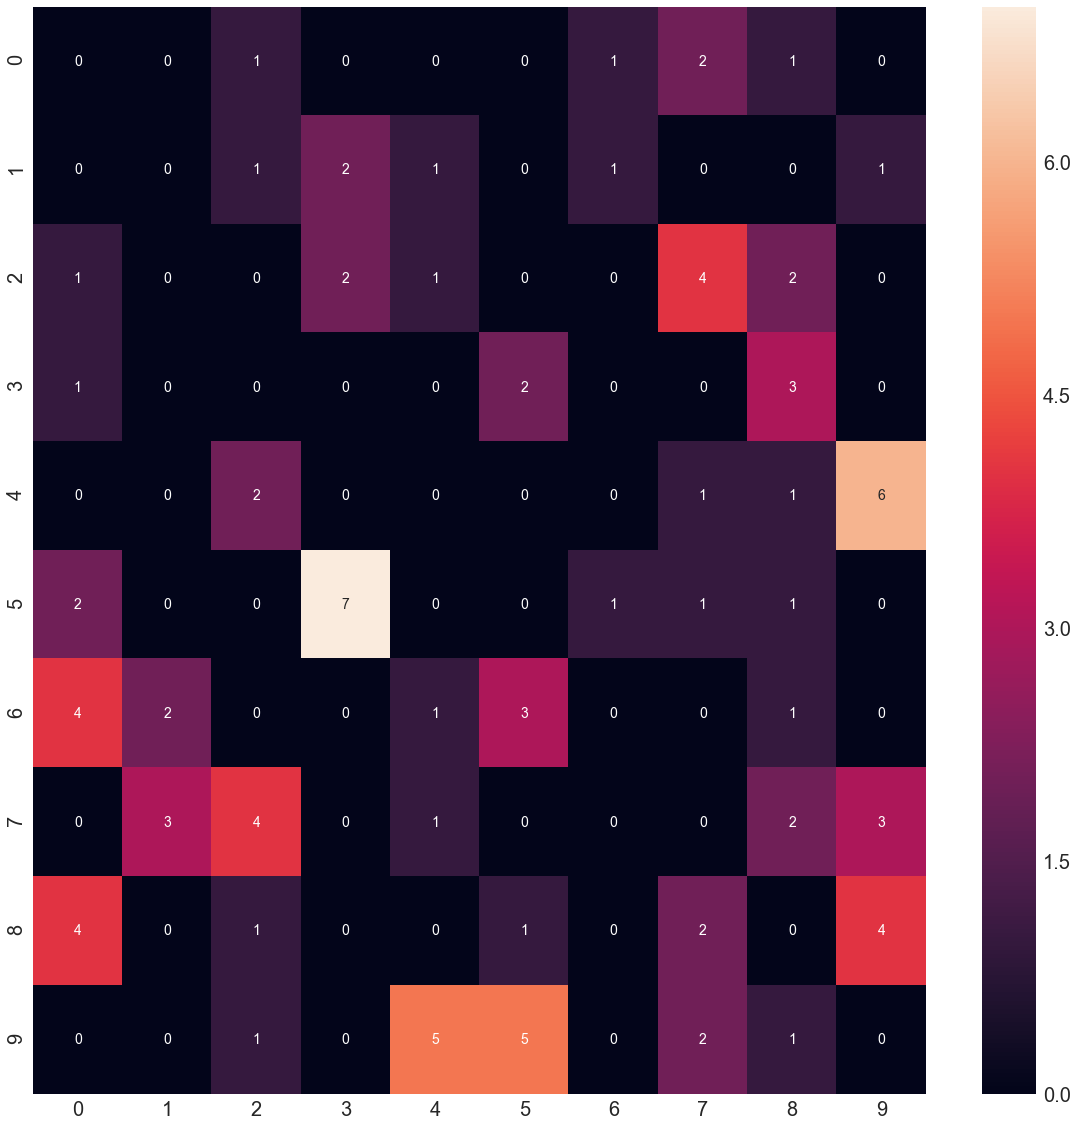

In [29]:
df_cm = pd.DataFrame(err_confusion_matrix.numpy(), range(10), range(10))

plt.figure(figsize = (20,20))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, fmt='g')

In [30]:
sn.set(font_scale=1)
sn.set_style("whitegrid", {'axes.grid' : False})

In [31]:
f=lambda i, a: ({k: len(v) for k, v in a.items()} if [a[x].append(i) for x in i] else {})

In [32]:
errors=f(errors_labels[:,1],defaultdict(list))

# errors distribution

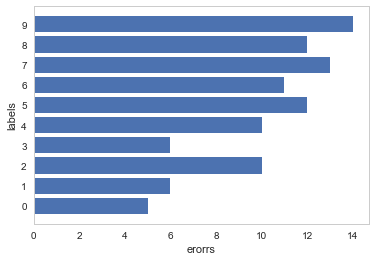

In [33]:
plt.figure(figsize=(6,4))
plt.barh(*zip(*errors.items()))
plt.yticks(range(10))
plt.xlabel('erorrs')
plt.ylabel('labels')
plt.show()

# errors features

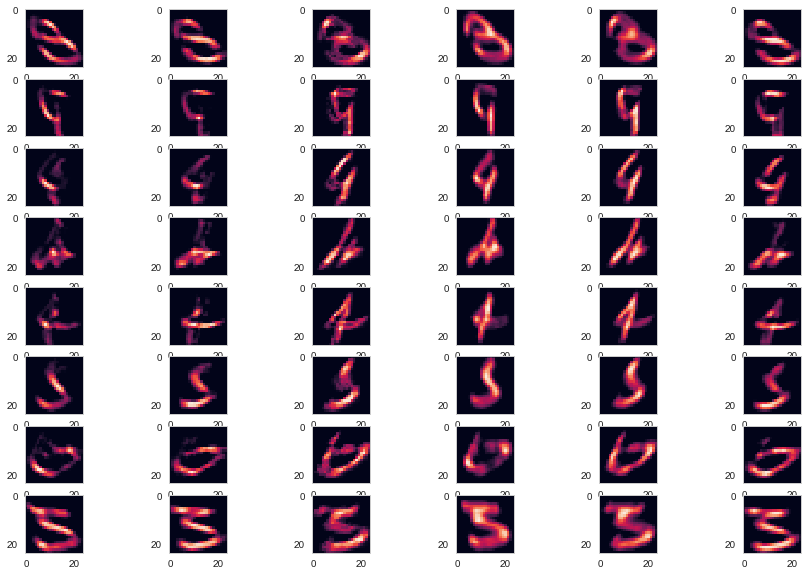

In [34]:
plt.figure(figsize=(15,10))
show_features(net.features_1(errors_imgs[:8]).detach().cpu())

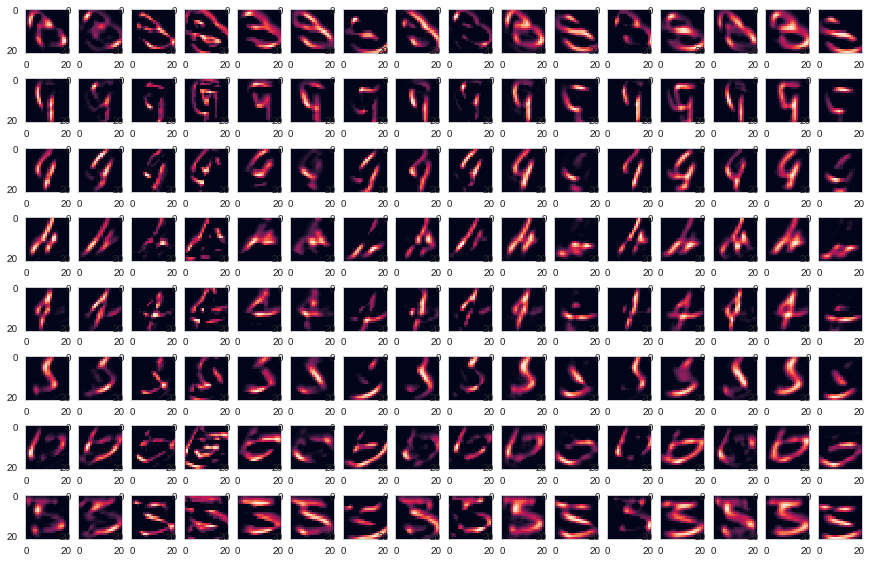

In [35]:
plt.figure(figsize=(15,10))
show_features(net.features_2(errors_imgs[:8]).detach().cpu())

# errors examples

PREDICTED:  8 != TRUE:  3


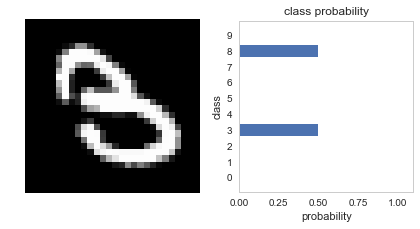

FEATURES_1 OF FALSE 3


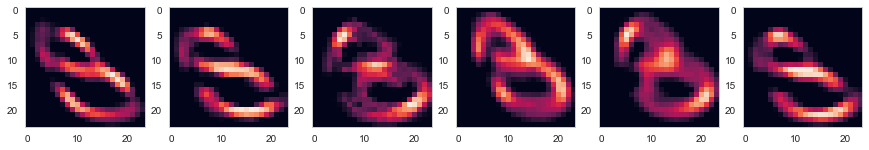

FEATURES_1 OF TRUE 3


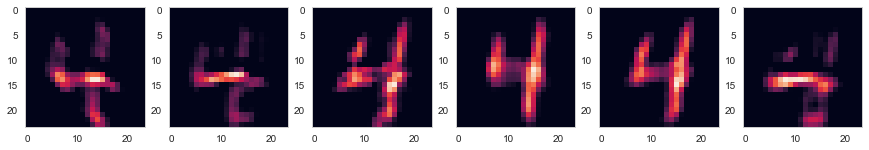

FEATURES_1 OF TRUE 8


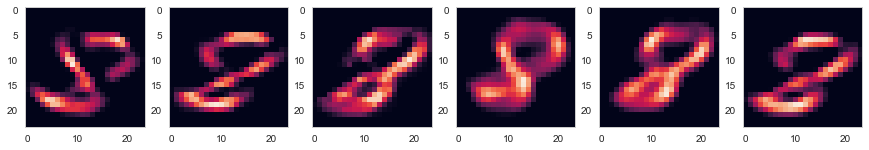

FEATURES_2 OF FALSE 3


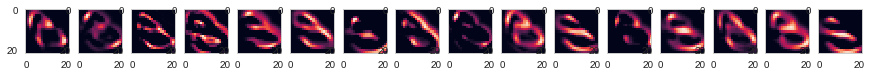

FEATURES_2 OF TRUE 3


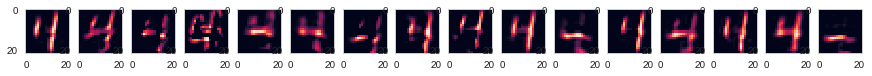

FEATURES_2 OF TRUE 8


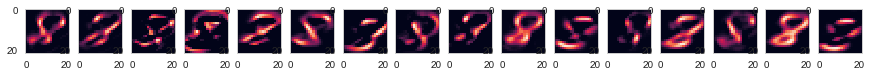

PREDICTED:  5 != TRUE:  9


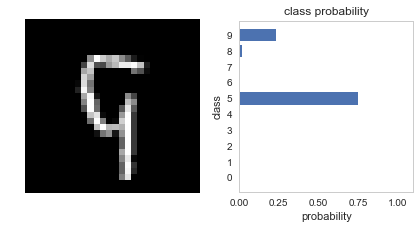

FEATURES_1 OF FALSE 9


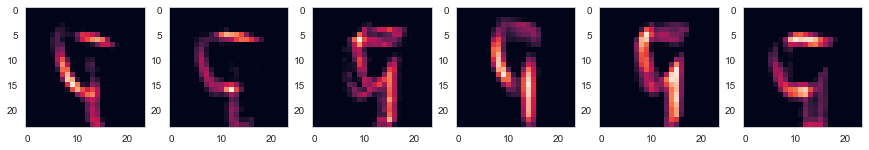

FEATURES_1 OF TRUE 9


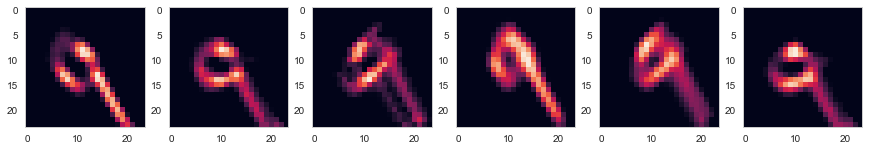

FEATURES_1 OF TRUE 5


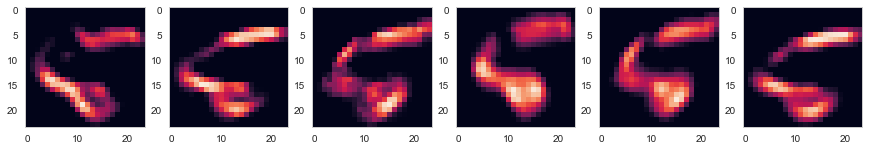

FEATURES_2 OF FALSE 9


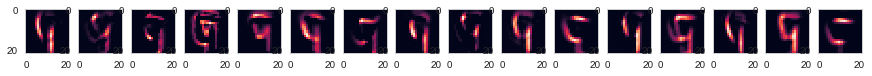

FEATURES_2 OF TRUE 9


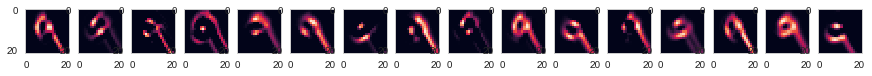

FEATURES_2 OF TRUE 5


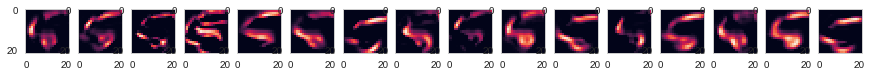

PREDICTED:  9 != TRUE:  4


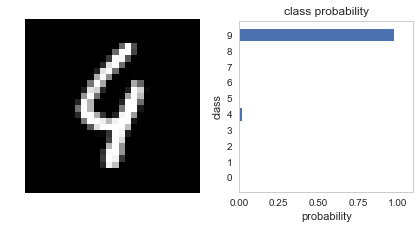

FEATURES_1 OF FALSE 4


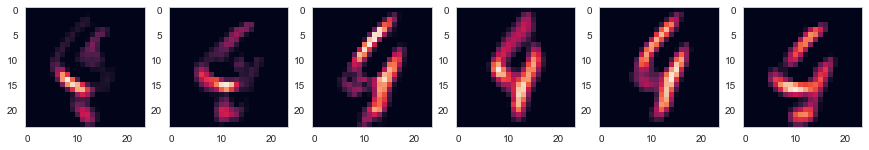

FEATURES_1 OF TRUE 4


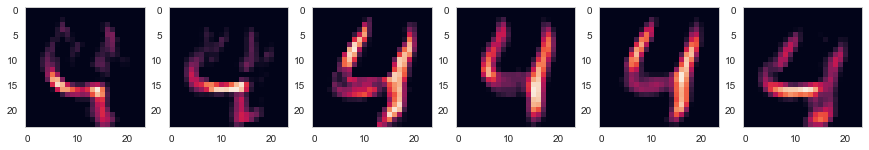

FEATURES_1 OF TRUE 9


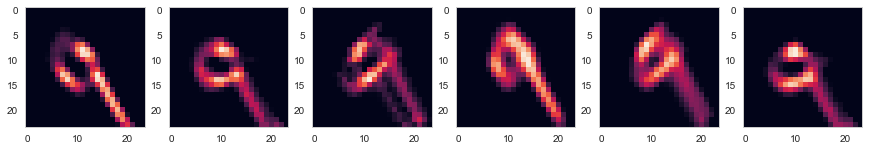

FEATURES_2 OF FALSE 4


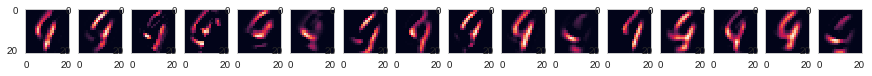

FEATURES_2 OF TRUE 4


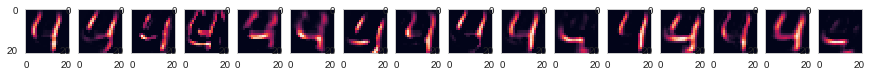

FEATURES_2 OF TRUE 9


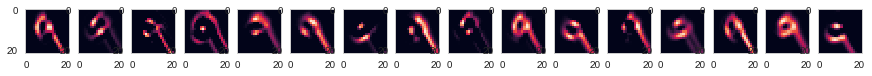

PREDICTED:  2 != TRUE:  4


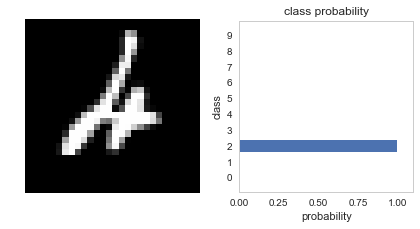

FEATURES_1 OF FALSE 4


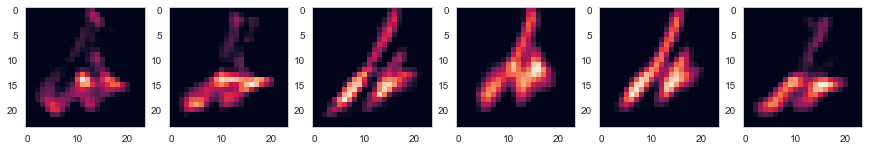

FEATURES_1 OF TRUE 4


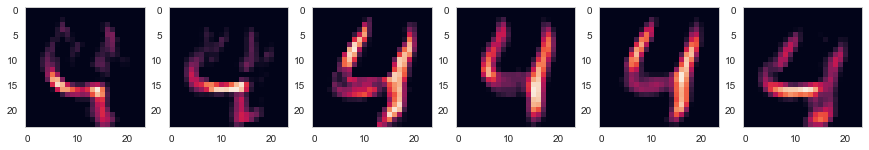

FEATURES_1 OF TRUE 2


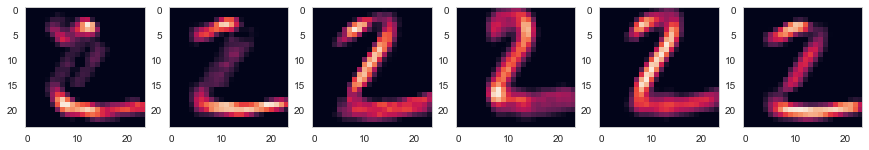

FEATURES_2 OF FALSE 4


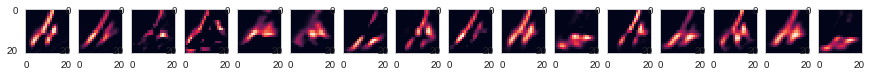

FEATURES_2 OF TRUE 4


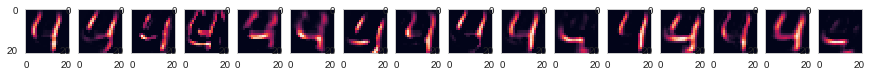

FEATURES_2 OF TRUE 2


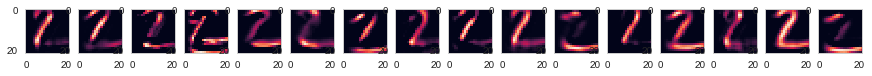

PREDICTED:  2 != TRUE:  4


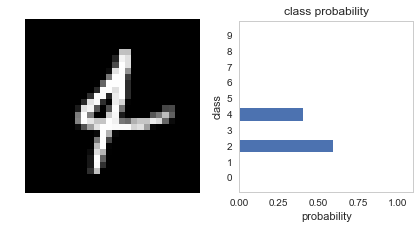

FEATURES_1 OF FALSE 4


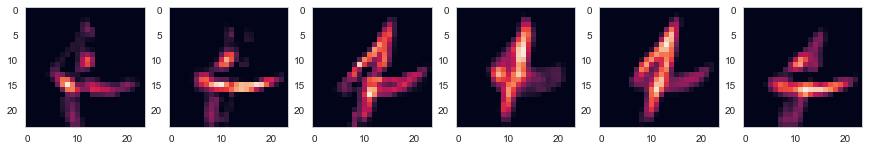

FEATURES_1 OF TRUE 4


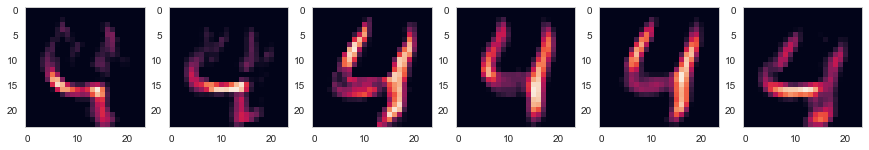

FEATURES_1 OF TRUE 2


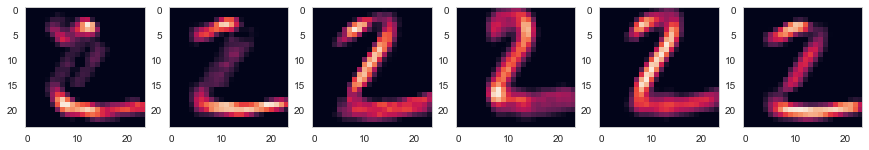

FEATURES_2 OF FALSE 4


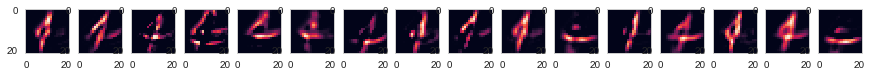

FEATURES_2 OF TRUE 4


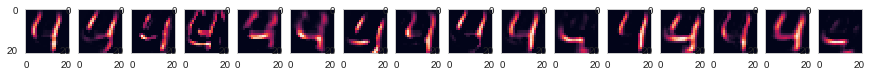

FEATURES_2 OF TRUE 2


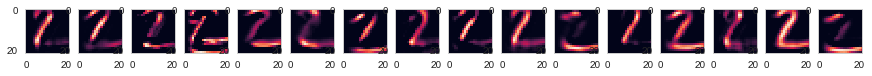

PREDICTED:  3 != TRUE:  5


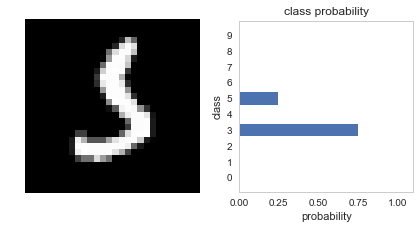

FEATURES_1 OF FALSE 5


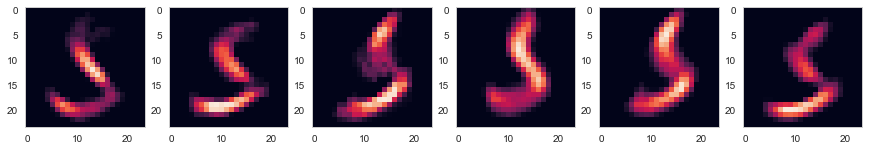

FEATURES_1 OF TRUE 5


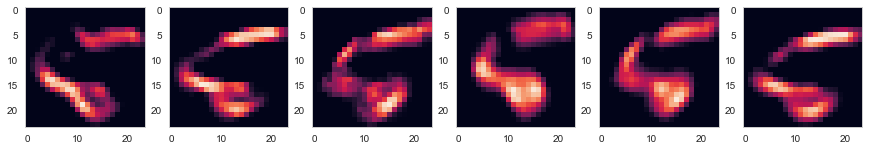

FEATURES_1 OF TRUE 3


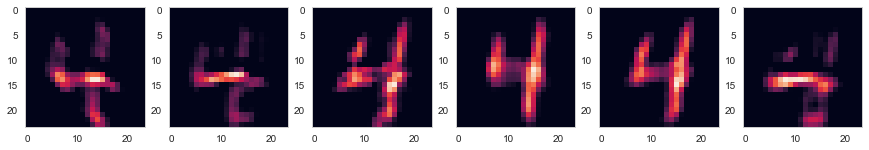

FEATURES_2 OF FALSE 5


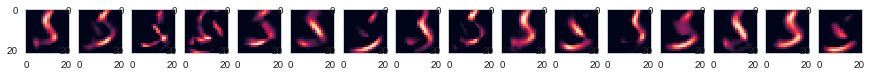

FEATURES_2 OF TRUE 5


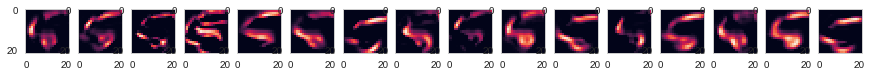

FEATURES_2 OF TRUE 3


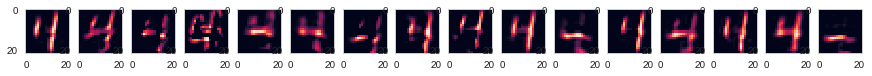

PREDICTED:  0 != TRUE:  6


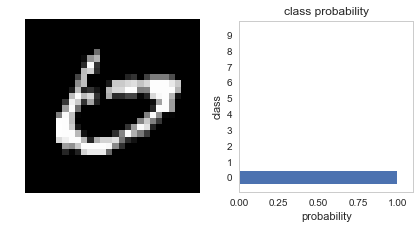

FEATURES_1 OF FALSE 6


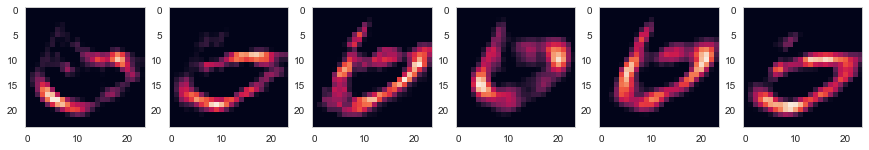

FEATURES_1 OF TRUE 6


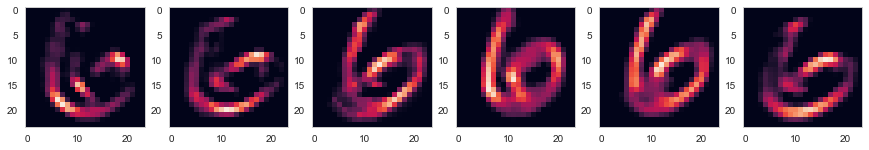

FEATURES_1 OF TRUE 0


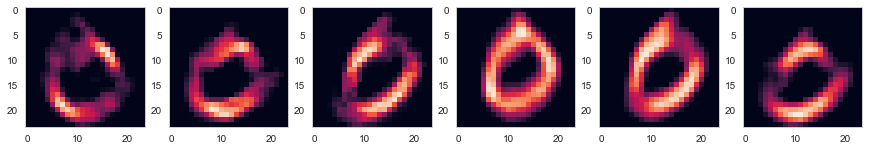

FEATURES_2 OF FALSE 6


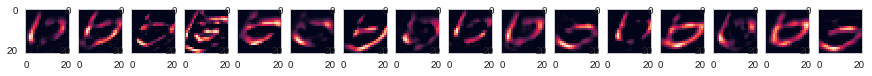

FEATURES_2 OF TRUE 6


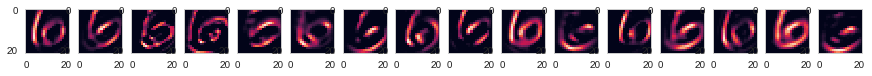

FEATURES_2 OF TRUE 0


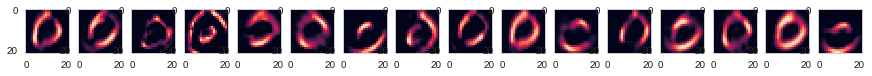

PREDICTED:  5 != TRUE:  3


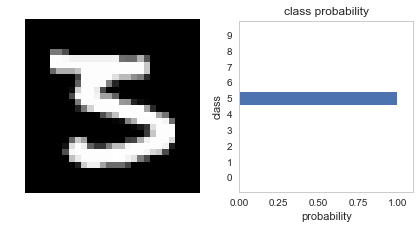

FEATURES_1 OF FALSE 3


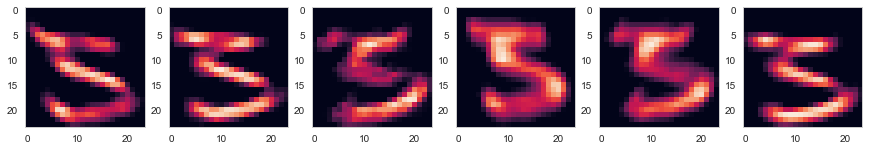

FEATURES_1 OF TRUE 3


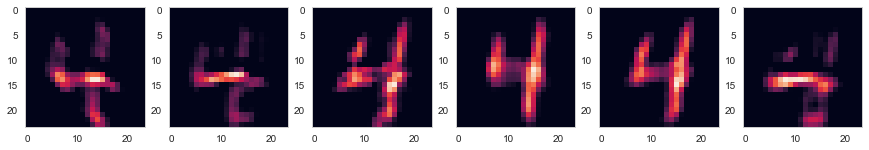

FEATURES_1 OF TRUE 5


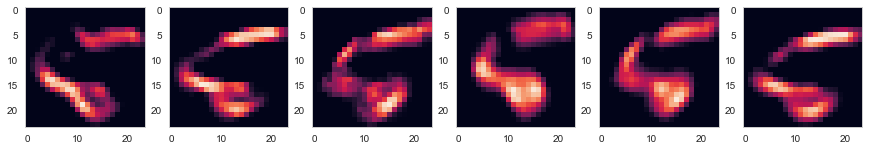

FEATURES_2 OF FALSE 3


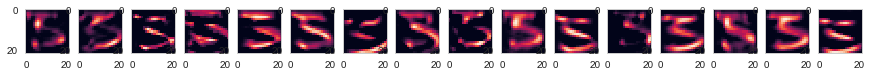

FEATURES_2 OF TRUE 3


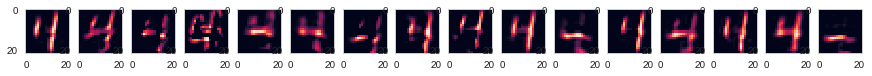

FEATURES_2 OF TRUE 5


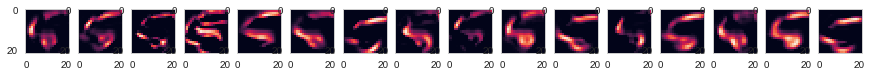

PREDICTED:  2 != TRUE:  8


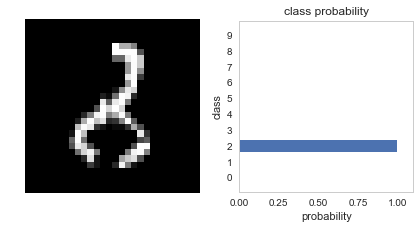

FEATURES_1 OF FALSE 8


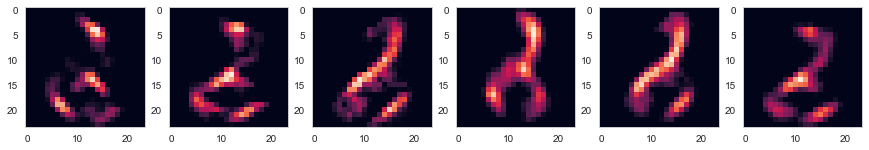

FEATURES_1 OF TRUE 8


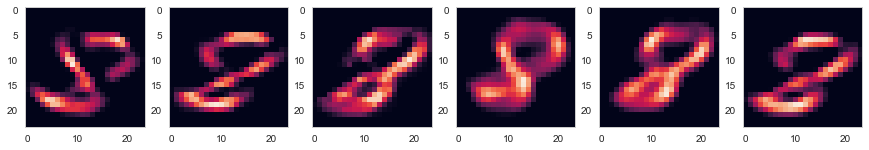

FEATURES_1 OF TRUE 2


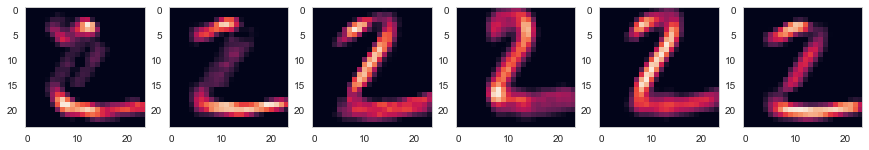

FEATURES_2 OF FALSE 8


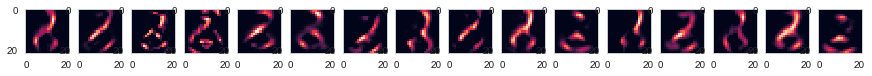

FEATURES_2 OF TRUE 8


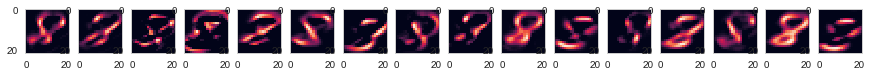

FEATURES_2 OF TRUE 2


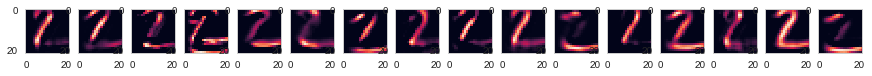

PREDICTED:  7 != TRUE:  2


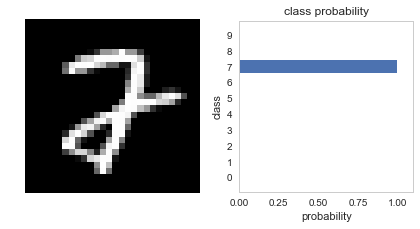

FEATURES_1 OF FALSE 2


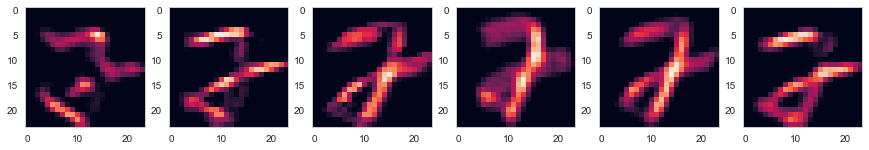

FEATURES_1 OF TRUE 2


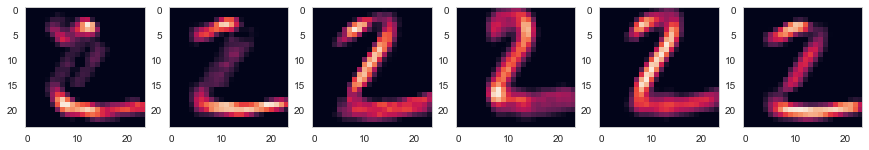

FEATURES_1 OF TRUE 7


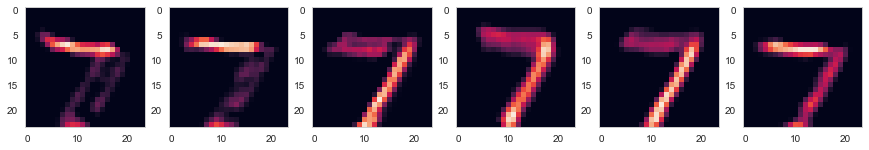

FEATURES_2 OF FALSE 2


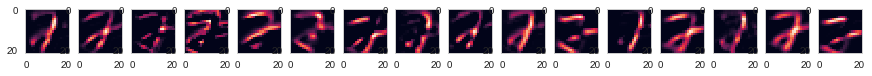

FEATURES_2 OF TRUE 2


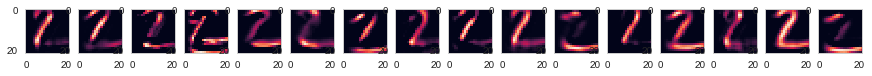

FEATURES_2 OF TRUE 7


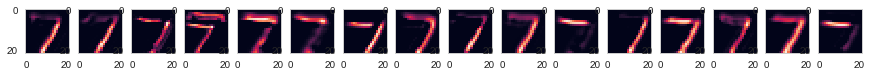

In [37]:
for img_indx in range(10):
    pred_digit=errors_labels[img_indx][0].item()
    true_digit=errors_labels[img_indx][1].item()
    print('PREDICTED: ', pred_digit, '!=','TRUE: ', true_digit)
    ps = net.forward(errors_imgs[img_indx].unsqueeze(0))
    view_classify(errors_imgs[img_indx].cpu(), torch.softmax(ps,dim=1))
    plt.show()
    
    print(f'FEATURES_1 OF FALSE {true_digit}')
    plt.figure(figsize=(15,10))
    show_features(net.features_1(errors_imgs[img_indx:img_indx+1].to(device)).detach().cpu())
    plt.show()

    print(f'FEATURES_1 OF TRUE {true_digit}')
    plt.figure(figsize=(15,10))
    show_features(net.features_1(correct_samples[true_digit].unsqueeze(0).to(device)).detach().cpu())
    plt.show()
    
    print(f'FEATURES_1 OF TRUE {pred_digit}')
    plt.figure(figsize=(15,10))
    show_features(net.features_1(correct_samples[pred_digit].unsqueeze(0).to(device)).detach().cpu())
    plt.show()
    
    print(f'FEATURES_2 OF FALSE {true_digit}')
    plt.figure(figsize=(15,10))
    show_features(net.features_2(errors_imgs[img_indx:img_indx+1].to(device)).detach().cpu())
    plt.show()
    
    print(f'FEATURES_2 OF TRUE {true_digit}')
    plt.figure(figsize=(15,10))
    show_features(net.features_2(correct_samples[true_digit].unsqueeze(0).to(device)).detach().cpu())
    plt.show()
    
    print(f'FEATURES_2 OF TRUE {pred_digit}')
    plt.figure(figsize=(15,10))
    show_features(net.features_2(correct_samples[pred_digit].unsqueeze(0).to(device)).detach().cpu())
    plt.show()

# kaggle submission

In [38]:
# net=torch.load('torch_mnist_model.pt')
# net.eval()

In [39]:
kaggle=pd.read_csv('test.csv')

In [40]:
kaggle.shape

(28000, 784)

In [41]:
kaggle=torch.from_numpy(kaggle.values)

In [42]:
kaggle=kaggle.view(28000,28,28).to(device)

In [43]:
# T = transforms.Compose([
#     transforms.Normalize((img_norm_mean,), (img_std,))
# ])
# kaggle=T(kaggle)

In [44]:
predictions=[]
with torch.no_grad():
    for i, data in enumerate(kaggle):
        images = data.to(device)
        outputs = net(images.float().unsqueeze(0).unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        predictions.append([i+1,predicted.item()])

In [45]:
predictions=pd.DataFrame(predictions)

In [46]:
predictions.columns=['ImageId','Label']

In [47]:
predictions.to_csv('submission.csv',sep=',',index=None)

# LeNet-5 (fewer number of cards) 30 epochs

![title](kaggle_mnist.png)

# LeNet-5 (original) 5 30 epochs

![title](kaggle_mnist2.png)

# LeNet-5 100 epochs

![title](kaggle_mnist3.png)

# LeNet-5 (greater number of cards) 100 epochs

![title](kaggle_mnist4.png)